# Construction of Route Graphs

In [1]:
import json
import time
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import isodate
import cvxpy as cp
import gurobipy
from functools import reduce

### Load Json

In [2]:
scenario = "sample_scenario.json"  # adjust path to the sample instance if it is not located there
with open(scenario) as fp:
    scenario = json.load(fp)

### Process section requirements

In [3]:
service_intentions = {}
for si in scenario['service_intentions']:
    requirements = {}
    for i,req in enumerate(si['section_requirements']):
        requirements[req['section_marker']] = {key:value for key,value in req.items()}
        if i == 0:
            requirements[req['section_marker']]['start_end'] = 'start'
        elif i == len(si['section_requirements']) - 1:
            requirements[req['section_marker']]['start_end'] = 'end'
        else: 
            requirements[req['section_marker']]['start_end'] = None
    service_intentions[si['id']] = requirements

#get resources
resources = {}
for resource in scenario['resources']:
    idx = resource['id']
    if idx in resources:
        print('something is wrong')
    resources[idx] = resource['release_time']

### Printing of nodes

In [4]:
def from_node_id(route_path, route_section, index_in_path):
    if "route_alternative_marker_at_entry" in route_section.keys() and \
            route_section["route_alternative_marker_at_entry"] is not None and \
            len(route_section["route_alternative_marker_at_entry"]) > 0:
                return "(" + str(route_section["route_alternative_marker_at_entry"][0]) + ")"
    else:
        if index_in_path == 0:  # can only get here if this node is a very beginning of a route
            return "(" + str(route_section["sequence_number"]) + "_beginning)"
        else:
            return "(" + (str(route_path["route_sections"][index_in_path - 1]["sequence_number"]) + "->" +
                          str(route_section["sequence_number"])) + ")"
def to_node_id(route_path, route_section, index_in_path):
    if "route_alternative_marker_at_exit" in route_section.keys() and \
            route_section["route_alternative_marker_at_exit"] is not None and \
            len(route_section["route_alternative_marker_at_exit"]) > 0:

                return "(" + str(route_section["route_alternative_marker_at_exit"][0]) + ")"
    else:
        if index_in_path == (len(route_path["route_sections"]) - 1): # meaning this node is a very end of a route
            return "(" + str(route_section["sequence_number"]) + "_end" + ")"
        else:
            return "(" + (str(route_section["sequence_number"]) + "->" +
                          str(route_path["route_sections"][index_in_path + 1]["sequence_number"])) + ")"

### Construct graph for every SI, and appropriate edge constraints

In [5]:
route_section_keys = ['penalty', 'minimum_running_time']
section_requirement_keys = ['start_end','min_stopping_time', 'entry_earliest', 'entry_latest',
                           'exit_earliest', 'exit_latest', 'entry_delay_weight',
                           'exit_delay_weight']

In [6]:
start_time = time.time()

# now build the graph. Nodes are called "previous_FAB -> next_FAB" within lineare abschnittsfolgen and "AK" if
# there is an Abschnittskennzeichen 'AK' on it
route_graphs = dict()
for route in scenario["routes"]:# iterates over si?
    
    print(f"\nConstructing route graph for route {route['id']}")
    # set global graph settings
    G = nx.DiGraph(route_id = route["id"], name="Route-Graph for route "+str(route["id"]))

    # add edges with data contained in the preprocessed graph
    for path in route["route_paths"]:#iterate over admissible routes
        print('new route')
        for (i, route_section) in enumerate(path["route_sections"]):
            sn = route_section['sequence_number']
            print("Adding Edge from {} to {} with sequence number {}".format(from_node_id(path, route_section, i), to_node_id(path, route_section, i), sn))
            edge_data = {}
            for key in route_section_keys:
                if key in route_section:
                    edge_data[key] = route_section[key]
                else:
                    edge_data[key] = None
                
            if 'resource_occupations' in route_section:
                resource_occupations = {}
                for resource in route_section['resource_occupations']:
                    idx = resource['resource']
                    R = resources[idx]
                    resource_occupations[idx] = R
                    #maximum? code below
                    R=[isodate.parse_duration(value).seconds for key,value in resource_occupations.items()]
            edge_data['resource_occupations'] = resource_occupations
            edge_data['R'] = max(R)
            
            #get section marker
            section_marker = None
            if 'section_marker' in route_section:
                try:
                    section_marker = route_section['section_marker'][0]
                except:
                    pass
            edge_data['section_marker'] = section_marker
            
            
            
            if section_marker in service_intentions[route['id']]:
                for key in section_requirement_keys:
                    if key in service_intentions[route['id']][section_marker]:
                            edge_data[key] = service_intentions[route['id']][section_marker][key]
        
            edge_data['sequence_number'] = sn
            
            print(edge_data)
            G.add_edge(from_node_id(path, route_section, i),
                       to_node_id(path, route_section, i),
                       edge_data = edge_data)

    route_graphs[route["id"]] = G

print("Finished building fahrweg-graphen in {} seconds".format(str(time.time() - start_time)))


Constructing route graph for route 111
new route
Adding Edge from (1_beginning) to (M1) with sequence number 1
{'penalty': None, 'minimum_running_time': 'PT53S', 'resource_occupations': {'A1': 'PT30S', 'AB': 'PT30S'}, 'R': 30, 'section_marker': 'A', 'start_end': 'start', 'entry_earliest': '08:20:00', 'entry_delay_weight': 1, 'exit_delay_weight': 1, 'sequence_number': 1}
Adding Edge from (M1) to (4->5) with sequence number 4
{'penalty': None, 'minimum_running_time': 'PT32S', 'resource_occupations': {'AB': 'PT30S'}, 'R': 30, 'section_marker': None, 'sequence_number': 4}
Adding Edge from (4->5) to (M2) with sequence number 5
{'penalty': None, 'minimum_running_time': 'PT32S', 'resource_occupations': {'B': 'PT30S'}, 'R': 30, 'section_marker': 'B', 'start_end': None, 'min_stopping_time': 'PT3M', 'exit_earliest': '08:30:00', 'entry_delay_weight': 1, 'exit_delay_weight': 1, 'sequence_number': 5}
Adding Edge from (M2) to (M3) with sequence number 6
{'penalty': None, 'minimum_running_time': 'PT

In [7]:
Lats = {}
for si in route_graphs:
    Latins = {}
    Latouts = {}
    for e in route_graphs[si].edges(data=True):
        if 'entry_latest' in e[2]['edge_data']:
            Latins[f'{e[0]},{e[1]}'] = e[2]['edge_data']['entry_latest']
        if 'exit_latest' in e[2]['edge_data']:
            Latouts[f'{e[0]},{e[1]}'] = e[2]['edge_data']['exit_latest']
        Lats[si] = {'LatIn': None, 'LatOut':None}
        Lats[si]['LatIn'] = Latins
        Lats[si]['LatOut'] = Latouts

In [8]:
Lats

{111: {'LatIn': {},
  'LatOut': {'(M4),(14_end)': '08:50:00', '(8->9),(9_end)': '08:50:00'}},
 113: {'LatIn': {},
  'LatOut': {'(M4),(14_end)': '08:16:00', '(8->9),(9_end)': '08:16:00'}}}

### Draw Graphs

for route in route_graphs:
    route_graph = route_graphs[route]

    """
    for node in route_graph.nodes():
        route_graph.node[node]['label'] = node

    edge_labels = {}
    for node1, node2, data in route_graph.edges(data=True):
        edge_labels[(node1, node2)] = data['sequence_number'] 

    for edge in route_graph.edges():
        route_graph.edges[edge]['label'] = edge_labels[edge]

    # export as graphML file, see below
    nx.write_graphml(route_graph, "graph-111"+".graphml")
    """
    edge_labels = {}
    for node1, node2, data in route_graph.edges(data=True):

        edge_labels[(node1, node2)] = data['edge_data']['sequence_number']

    # draw directly from networkx
    pos = nx.spring_layout(route_graph)
    nx.draw(route_graph, pos, edge_color='black', width=1, linewidths=1, node_size=500, node_color='pink', alpha=0.9)
    nx.draw_networkx_edge_labels(route_graph,pos,edge_labels=edge_labels,font_color='red')
    plt.show()

### Find all admissible routes

In [9]:
paths = {}
for si in service_intentions:
    startnodes=[]
    endnodes = []
    G = route_graphs[si]
    for edge in G.edges(data=True):
        if 'start_end' in edge[2]['edge_data']:
            if edge[2]['edge_data']['start_end'] == 'start':
                startnodes.append(edge[0])
            if edge[2]['edge_data']['start_end'] == 'end':
                endnodes.append(edge[1])
    paths_si = []
    for s in startnodes:
        for e in endnodes:
            for path in nx.all_simple_paths(G, source=s, target=e):
                paths_si.append([(path[i], path[i+1]) for i in range(len(path)-1)])
    paths[si] = paths_si

In [10]:
si_list = []
t_index_by_edge = {}
delta_index_by_edge = {}
edges_by_path = {}
get_index_by_delta = {}
j=0
k=0
for si in paths:
    pathlist = []
    ttemp = {}
    dtemp = {}
    for i,path in enumerate(paths[si]):
        srlist = []
        etemp = {}
        for sr in path:
            srlist.append((si,i,sr))
            if sr in ttemp:
                ttemp[sr].append(j)
            else:
                ttemp[sr] = [j]
            
            
            if sr in dtemp:
                dtemp[sr].append(k)
            else:
                dtemp[sr] = [k]
            
            etemp[sr] = j
            if k in get_index_by_delta:
                get_index_by_delta[k].append(j)
            else:
                get_index_by_delta[k] = [j]
            j+=1
        edges_by_path[k] = etemp
            
        k+=1
        pathlist.append(srlist)
    t_index_by_edge[si] = ttemp
    delta_index_by_edge[si] = dtemp
    si_list.append(pathlist)

In [11]:
xindex = {}
enum = 0
for si in service_intentions:
    xindexsi = {}
    for i,e in enumerate(route_graphs[si].edges):
        xindexsi[e] = i+enum
    enum+=i+1
    xindex[si] = xindexsi

In [12]:
import itertools
betaindex = []
for (si1, si2) in list(itertools.combinations([key for key in service_intentions],2)):
    intsc = list(set.intersection(set(route_graphs[si1].edges), set(route_graphs[si2].edges)))
    for e in intsc:
        betaindex.append((si1, si2, e))

In [13]:
def recursive_len(item):
    if type(item) == list:
        return sum(recursive_len(subitem) for subitem in item)
    else:
        return 1

In [14]:
t_len = recursive_len(si_list)
x_len = 0
delta_len = 0
for si in service_intentions:
    x_len += len(route_graphs[si].edges)
    delta_len += len(paths[si])
beta_len = len(betaindex)
total_length = t_len*2 + x_len + delta_len + beta_len
total_length

300

In [15]:
TL={}
i = 0
for si, si_id in zip(si_list, service_intentions):
    temp = {} 
    temp['t'] = recursive_len(si)
    temp['x'] = len(route_graphs[si_id].edges)
    temp['delta'] = len(paths[si_id])
    slacknum = 0
    for r in si:
        for rs in r:
            edge_data = route_graphs[si_id].edges[rs[2]]['edge_data']
            if 'entry_delay_weight' in edge_data and 'entry_latest' in edge_data:
                slacknum+=1
            if 'exit_delay_weight' in edge_data and 'exit_latest' in edge_data:
                slacknum+=1
            i+=1
    temp['slack'] = slacknum
    TL[si_id] = temp
slack_len = sum([TL[si]['slack'] for si in service_intentions])
total_length+=slack_len
TL

{111: {'t': 60, 'x': 14, 'delta': 9, 'slack': 9},
 113: {'t': 60, 'x': 14, 'delta': 9, 'slack': 9}}

### Variables

|t_in| = sum of the length of all service intentions, total number of paths per si and route sections per path  
|t_out| same as t_in  

|x| all service intentions and their route sections

|delta| all service intentions and their paths

$v = [t_{in}, t_{out} , x, \delta]$

#### Minimize objective function

$J(x)=\{ \frac{1}{60} \sum_{SI, R, RS} win_{rs}max(0, 
t_{si,r,rs}^{in} - LatIn_{si,rs}) + wout_{rs} max(0, t_{si,r,rs}^{out} - LatOut_{si,rs}) + p_{si,rs}x_{si,rs} \}$  



#### Subject to

time into a section comes before time out: 


(1)  $t_{si,r,rs}^{in} \leq t_{si,r,rs}^{out}$  

time into next section comes after time out from previous section:  
(2)  $t_{si,r,rs}^{out} = t_{si,r,rs+1}^{in}$

if r is the selected path, satisfy minimum running and stopping time:  
(3)  $t_{si,r,rs}^{out} - t_{si,r,rs}^{in} \geq mrt_{si, r, rs} + mst_{si, r, rs} - M(1-\delta_{si,r})$

Earliest in constraint:  
(4)  $t_{si,r,rs}^{in} \geq EarIn_{si,r,rs} - M(1-\delta_{si,r})$  

Earliest out constraint:  
(5)  $t_{si,r,rs}^{out} \geq EarOut_{si,r,rs} - M(1-\delta_{si,r})$

Select only one path to every service:  
(6)  $\sum_{r \in P} \delta_{si,r} = 1$  

All route sections on the chosen track are occupied  
(7)  $x_{si, re} \geq \delta_{si, r}$  

(8) $t_{si_1,r_1,re}^{in} - t_{si_2,r_2,re}^{in} \leq M(1-\beta_{si_1,si_2,re}) + M(2- \delta_{si_1,r_1} - \delta_{si_2,r_2})$  

(9) $t_{si_2,r_2,re}^{in} - t_{si_1,r_1,re}^{in} + \epsilon \leq M\beta_{si_1,si_2,re} + M(2- \delta_{si_1,r_1} - \delta_{si_2,r_2})$

(10) $t_{si_1,r_1,re}^{out} - t_{si_2,r_2,re}^{in} + R \leq M(1-\beta_{si_1,si_2,re}) + M(2- \delta_{si_1,r_1} - \delta_{si_2,r_2})$

(11) $t_{si_2,r_2,re}^{out} - t_{si_1,r_1,re}^{in} + R \leq M\beta_{si_1,si_2,re} + M(2- \delta_{si_1,r_1} - \delta_{si_2,r_2})$

LatIn = entry_latest  
EarOut = exit_earliest  
EarIn = entry_earliest  
LatOut = exit_latest

In [16]:
from time import strftime
from time import gmtime

def str_to_sec(s):
    s=s.split(':')
    return int(s[0])*60*60+int(s[1])*60+int(s[2])
def sec_to_str(x):
    return strftime("%H:%M:%S", gmtime(x))

## Modelling approach

### Constraints

In [17]:
Mmrtmst = [1]
MEarOut = [1]
MEarIn = [1]
for si in route_graphs:
    for e in route_graphs[si].edges(data=True):
        edge_data = e[2]['edge_data']
        if ('exit_earliest' in edge_data):
            EarOut = str_to_sec(edge_data['exit_earliest'])
            MEarOut.append(EarOut)
        if ('entry_earliest' in edge_data):
            EarIn = str_to_sec(edge_data['entry_earliest'])
            MEarIn.append(EarIn)
        if ('min_stopping_time' in edge_data) or ('minimum_running_time' in edge_data):
            mst = 0
            mrt = 0
            if 'min_stopping_time' in edge_data:
                mst = isodate.parse_duration(edge_data['min_stopping_time']).seconds
            if 'minimum_running_time' in edge_data:
                mrt = isodate.parse_duration(edge_data['minimum_running_time']).seconds
            Mmrtmst.append(mrt+mst)

In [99]:
A = np.array([None]*total_length)
b = np.array([None])
c = np.zeros(total_length)
testv = [None]*total_length


currlen = 0
bool_idx = []
for si, si_id in zip(si_list, service_intentions):
    tempsum = 0
    j=0
    sumtemp = np.zeros(total_length)
    i =0
    s=0
    for r, path in zip(si, paths[si_id]):
        for enum, rs in enumerate(r):
            edge_data = route_graphs[si_id].edges[rs[2]]['edge_data']
            #slack
            tin_idx = currlen + i + TL[si_id]['slack'] 
            tout_idx = currlen + i + TL[si_id]['slack'] + TL[si_id]['t']
            delta_idx = currlen + j + TL[si_id]['slack'] + 2*TL[si_id]['t']
            ad_x = 0
            for t in TL:
                if t==si_id:
                    break
                ad_x += TL[si_id]['x']
            x_idx = currlen + xindex[si_id][rs[2]] + TL[si_id]['slack'] + 2*TL[si_id]['t'] + TL[si_id]['delta'] -ad_x
            
            bool_idx.append(delta_idx)
            bool_idx.append(x_idx)
            
            if 'entry_delay_weight' in edge_data and 'entry_latest' in edge_data:
                temp = np.zeros(total_length)
                temp[currlen + s] = -1
                temp[tin_idx] = float(edge_data['entry_delay_weight'])
                tempb = np.array([float(edge_data['entry_delay_weight'])*str_to_sec(edge_data['entry_latest'])])
                b = np.vstack((b,tempb))
                A = np.vstack((A,temp))
                
                temp = np.zeros(total_length)
                temp[currlen + s] = -1
                tempb = np.array([0])
                b = np.vstack((b,tempb))
                A = np.vstack((A,temp))
                
                c[currlen + s] = 1
            
                testv[currlen + s] = f'slack_{s}_{si_id}'
                s+=1
                
            if 'exit_delay_weight' in edge_data and 'exit_latest' in edge_data:
                temp = np.zeros(total_length)
                temp[currlen + s] = -1
                temp[tout_idx] = float(edge_data['exit_delay_weight'])
                tempb = np.array([float(edge_data['exit_delay_weight'])*str_to_sec(edge_data['exit_latest'])])
                b = np.vstack((b,tempb))
                A = np.vstack((A,temp))
                
                temp = np.zeros(total_length)
                temp[currlen + s] = -1
                tempb = np.array([0])
                b = np.vstack((b,tempb))
                A = np.vstack((A,temp))
                
                c[currlen + s] = 1
                
                testv[currlen + s] = f'slack_{s}_{si_id}'
                s+=1

            
            temp = np.zeros(total_length)
            temp[tin_idx] = -1
            tempb = np.array([0])
            b = np.vstack((b,tempb))
            A = np.vstack((A,temp))
            testv[tin_idx] = f'tin_{i}_{si_id}'
            
            temp = np.zeros(total_length)
            temp[tout_idx] = -1
            tempb = np.array([0])
            b = np.vstack((b,tempb))
            A = np.vstack((A,temp))
            testv[tout_idx] = f'tout_{i}_{si_id}'
            
            #(1)
            temp = np.zeros(total_length)
            temp[tin_idx] = 1
            temp[tout_idx] = -1
            tempb = np.array([0])
            b = np.vstack((b,tempb))
            A = np.vstack((A,temp))
            # (2)
            if enum!=len(r)-1:
                temp = np.zeros(total_length)
                temp[tin_idx+1] = 1
                temp[tout_idx]=-1
                tempb = np.array([0])
                b = np.vstack((b,tempb))
                A = np.vstack((A,temp))
                temp = -1*temp.copy()
                A = np.vstack((A,temp))
                b = np.vstack((b,tempb))

            #(3)
            M=max(Mmrtmst)
            if ('min_stopping_time' in edge_data) or ('minimum_running_time' in edge_data):
                mst = 0
                mrt = 0
                if 'min_stopping_time' in edge_data:
                    mst = isodate.parse_duration(edge_data['min_stopping_time']).seconds
                if 'minimum_running_time' in edge_data:
                    mrt = isodate.parse_duration(edge_data['minimum_running_time']).seconds

                temp = np.zeros(total_length)
                temp[tin_idx] = 1
                temp[tout_idx] = -1
                temp[delta_idx] = M
                tempb = np.array([M-mrt-mst])
                b = np.vstack((b,tempb))
                A = np.vstack((A,temp))

            # (4)
            M=max(MEarIn)
            if ('entry_earliest' in edge_data):
                EarIn = str_to_sec(edge_data['entry_earliest'])
                
                temp = np.zeros(total_length)
                temp[tin_idx] = -1
                temp[delta_idx] = M
                tempb = np.array([M-EarIn])
                b = np.vstack((b,tempb))
                A = np.vstack((A,temp))

            #(5)
            M=max(MEarOut)    
            if ('exit_earliest' in edge_data):
                EarOut = str_to_sec(edge_data['exit_earliest'])
                
                temp = np.zeros(total_length)
                temp[tout_idx] = -1
                temp[delta_idx] = M
                tempb = np.array([M-EarOut])
                b = np.vstack((b,tempb))
                A = np.vstack((A,temp))

            # (7)
            temp = np.zeros(total_length)
            temp[delta_idx] = 1
            temp[x_idx] = -1
            tempb = np.array([0])
            b = np.vstack((b,tempb))
            A = np.vstack((A,temp))
            
            testv[x_idx] = f'x_{xindex[si_id][rs[2]]}_{si_id}'
            testv[delta_idx] = f'delta_{j}_{si_id}'
            i+=1
        # (6)
        sumtemp[delta_idx] = 1
        j+=1
    tempb = np.array([1])
    b = np.vstack((b,tempb))
    A = np.vstack((A,sumtemp))
    sumtemp = -1*sumtemp.copy()
    tempb = -1*tempb.copy()
    b = np.vstack((b,tempb))
    A = np.vstack((A,sumtemp))
    currlen += TL[si_id]['slack'] + 2*TL[si_id]['t'] + TL[si_id]['delta'] + TL[si_id]['x']




A_coup = np.array([None]*total_length)
b_coup = np.array([None])

i = 0
eps = 0
M = 100000
R=0
LenSI = total_length - beta_len
for (si1, si2, e) in betaindex:
    deltaidx1 = delta_index_by_edge[si1][e]
    deltaidx2 = delta_index_by_edge[si2][e]
    
    
    prevsi = []
    for siprevel in [si for si in service_intentions]:
        if siprevel==si1:
            break
        prevsi.append(siprevel)
    adjuster1 = sum([TL[siprevel]['slack'] + 2*TL[siprevel]['t']+TL[siprevel]['delta']+TL[siprevel]['x'] for siprevel in prevsi])
    
    prevsi = []
    for siprevel in [si for si in service_intentions]:
        if siprevel==si2:
            break
        prevsi.append(siprevel)
    adjuster2 = sum([TL[siprevel]['slack'] + 2*TL[siprevel]['t']+TL[siprevel]['delta']+TL[siprevel]['x'] for siprevel in prevsi])
    
    
    for idx1 in deltaidx1:
        for idx2 in deltaidx2:
            tin1_idx = edges_by_path[idx1][e] - adjuster1 + TL[si_id]['slack']
            tin2_idx = edges_by_path[idx2][e] - adjuster2 + TL[si_id]['slack']
            tout1_idx = edges_by_path[idx1][e] - adjuster1 + TL[si_id]['slack'] + TL[si_id]['t']
            tout2_idx = edges_by_path[idx2][e] - adjuster2 + TL[si_id]['slack'] + TL[si_id]['t']
            delta1_idx = idx1+TL[si_id]['slack']+2*TL[si1]['t'] - adjuster1
            delta2_idx = idx2+TL[si_id]['slack']+2*TL[si1]['t'] - adjuster2
            
            temp = np.zeros(total_length)
            temp[tin1_idx] = 1
            temp[tin2_idx] = -1
            temp[delta1_idx] = M
            temp[delta2_idx] = M
            temp[LenSI+i] = M
            tempb = np.array([3*M])
            b_coup = np.vstack((b,tempb))
            A_coup = np.vstack((A,temp))
            
            
            temp = np.zeros(total_length)
            temp[tin1_idx] = -1
            temp[tin2_idx] = 1
            temp[delta1_idx] = M
            temp[delta2_idx] = M
            temp[LenSI+i] = -M
            tempb = np.array([2*M-eps])
            b_coup = np.vstack((b,tempb))
            A_coup = np.vstack((A,temp))
            
            
            temp = np.zeros(total_length)
            temp[tin2_idx] = -1
            temp[tout1_idx] = 1
            temp[delta1_idx] = M
            temp[delta2_idx] = M
            temp[LenSI+i] = M
            tempb = np.array([3*M-R])
            b_coup = np.vstack((b,tempb))
            A_coup = np.vstack((A,temp))
            
            
            temp = np.zeros(total_length)
            temp[tin1_idx] = -1
            temp[tout2_idx] = 1
            temp[delta1_idx] = M
            temp[delta2_idx] = M
            temp[LenSI+i] = -M
            tempb = np.array([2*M-R])
            b_coup = np.vstack((b,tempb))
            A_coup = np.vstack((A,temp))
    testv[LenSI+i] = f'beta_{i}'       
    bool_idx.append(LenSI+i)
    i+=1

bool_idx =list(set(bool_idx))
A=A[1:]
b=b[1:].flatten()

A_coup=A_coup[1:]
b_coup=b_coup[1:].flatten()

### Objective function

### Solver

In [100]:
bool_vars_idx = [(x,) for x in bool_idx]

x = cp.Variable(A.shape[1], boolean = bool_vars_idx)

p = cp.Problem(cp.Minimize(c.T@x),
                 [np.vstack((A,A_coup))@x<=np.concatenate((b,b_coup))])
p.solve(solver = 'MOSEK', verbose = True)

                                     CVXPY                                     
                                    v1.1.14                                    
(CVXPY) Aug 21 04:24:02 PM: Your problem has 318 variables, 1 constraints, and 0 parameters.
(CVXPY) Aug 21 04:24:02 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 21 04:24:02 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 21 04:24:02 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 21 04:24:02 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Aug 21 04:24:02 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing 

0.0

### Lagrangian relaxation

### Display solution

In [54]:
def display_solution(tin, tout, deltas, xs):
    deltas = deltas.value
    tin = tin.value
    tout = tout.value
    xs = xs.value
    #betas = betas.value
    ad_paths = np.where(deltas==1)[0]
    paths_flat = []
    timetable = {}
    penalty = 0
    for si in paths:
        paths_flat += paths[si]
    for (si,ad_path) in zip(service_intentions, ad_paths):
        p = paths_flat[ad_path]
        timetable[si] = {'tin': [], 'tout':[]}
        for idx,e in zip(get_index_by_delta[ad_path],p):
            timetable[si]['tin'].append((tin[idx]))
            timetable[si]['tout'].append((tout[idx]))
            estr = e[0]+','+e[1]
            print(f'si: {si}, edge: {estr}, tin: {sec_to_str(tin[idx])}, tout: {sec_to_str(tout[idx])}')
            if estr in Lats[si]['LatIn']:
                #print('LatIn', Lats[si]['LatIn'][estr])
                pen = max(0,tin[idx] - str_to_sec(Lats[si]['LatIn'][estr]))
                penalty+=pen
                print('penalty:', pen)
            if estr in Lats[si]['LatOut']:
                #print('LatOut', Lats[si]['LatOut'][estr])
                pen= max(0,tout[idx] - str_to_sec(Lats[si]['LatOut'][estr]))
                print('penalty:', pen)
                penalty+=pen
            #print(route_graphs[si].edges[e])
    import matplotlib.pyplot as plt
    plt.figure(figsize = (20,15))
    s=100
    for si in timetable:
        plt.scatter(range(len(timetable[si]['tin'])),timetable[si]['tin'], marker = 'o', label = si, s=s)
        plt.scatter(range(1,len(timetable[si]['tout'])+1),timetable[si]['tout'], marker = 'x', label = si, s=s)
    plt.legend()

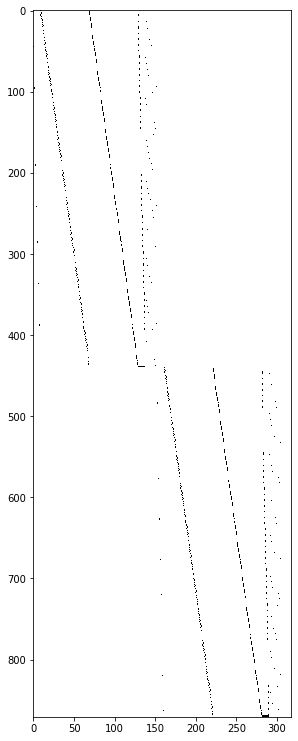

In [88]:
A = A.astype(float)
A[A.nonzero()]=1
from matplotlib import pyplot as plt
(x,y) = A.shape
S=5
plt.figure(figsize = (S,int(S*x/y)))
plt.imshow(A, cmap='Greys',  interpolation='nearest')

### Constraint check